In [5]:
!pip install dowhy
!pip install econml
!pip install cdt
!pip install lightgbm
!pip install graphviz

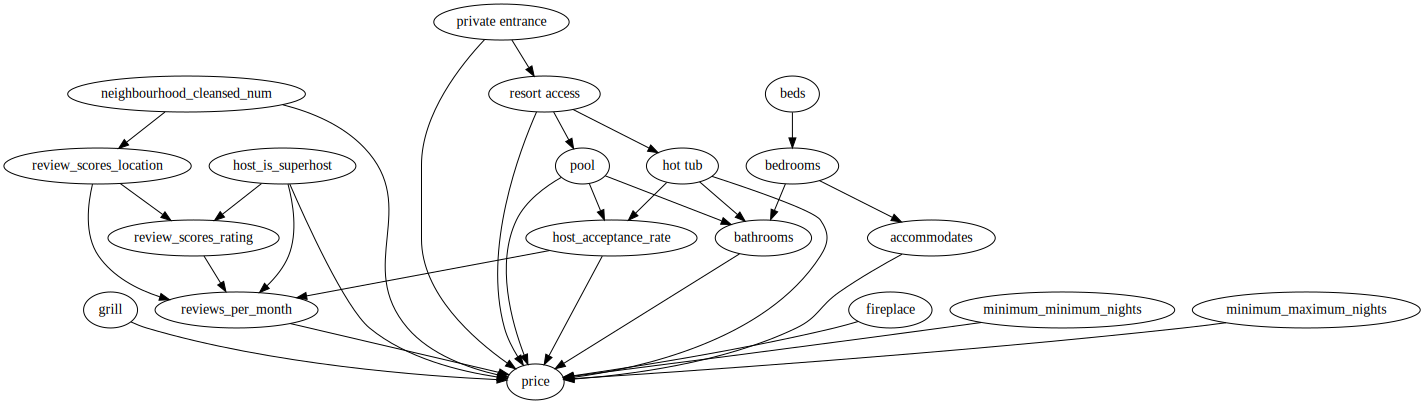

In [15]:
import graphviz

# Given DOT representation
causal_graph_updated = f"""
digraph {{
    grill -> price;
    pool -> price;
    "hot tub" -> price;
    "hot tub" -> bathrooms;
    pool -> bathrooms;
    "private entrance" -> price;
    "private entrance" -> "resort access";
    fireplace -> price;

    neighbourhood_cleansed_num -> price;
    neighbourhood_cleansed_num -> review_scores_location;
    review_scores_location -> review_scores_rating;
    review_scores_location -> reviews_per_month;
    review_scores_rating -> reviews_per_month;
    reviews_per_month -> price;
    host_is_superhost -> reviews_per_month;
    host_is_superhost -> price;
    host_is_superhost -> review_scores_rating;
    host_acceptance_rate -> reviews_per_month;
    host_acceptance_rate -> price;
    beds -> bedrooms;
    bedrooms -> accommodates;
    bedrooms -> bathrooms;
    accommodates -> price;
    "resort access" -> pool;
    "resort access" -> "hot tub";
    pool -> host_acceptance_rate;
    "hot tub" -> host_acceptance_rate;
    bathrooms -> price;
    "prop
    minimum_minimum_nights -> price;
    minimum_maximum_nights -> price;

    "resort access" -> price;
}}
"""



#visualize the updated causal graph
graph = graphviz.Source(causal_graph_updated)
graph # display the graph

In [35]:

from google.colab import files


uploaded = files.upload()

Saving df_selected1.csv to df_selected1 (1).csv


In [36]:
import pandas as pd

# Read the CSV file into a DataFrame
nashvilleDF = pd.read_csv('df_selected1.csv')
nasvilleDF = nashvilleDF.astype(float)
nashvilleDF.head()

,grill,private entrance,free parking,review_scores_location,resort access,review_scores_rating,bedrooms,beds,pool,host_acceptance_rate,...,prop_Entire condo,prop_Entire guest suite,prop_Entire guesthouse,prop_Entire home,prop_Entire rental unit,prop_Entire townhouse,prop_Hotel,prop_Private room,room_Entire home/apt,room_Private room
0,0,0,0,4.92,0,4.95,1,1,0,0,...,0,0,0,0,0,0,0,1,0,1
1,0,0,1,4.94,0,4.94,1,1,0,93,...,0,0,0,0,0,0,0,1,0,1
2,0,0,0,4.96,0,4.91,2,2,0,100,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,4.74,0,4.77,1,2,0,91,...,0,0,0,0,0,0,0,1,0,1
4,0,0,1,4.47,0,4.71,1,3,0,91,...,0,0,0,0,0,0,0,1,0,1


In [37]:
# Drop rows where any of the specified columns has a value of 1
columns_to_check = ['prop_Entire condo', 'prop_Entire guest suite', 'prop_Entire guesthouse',
                    'prop_Entire rental unit', 'prop_Entire townhouse', 'prop_Hotel',
                    'prop_Private room', 'free parking', 'room_Private room']

nashvilleDF = nashvilleDF[~nashvilleDF[columns_to_check].eq(1).any(axis=1)]

# Drop 'id' and the specified columns
columns_to_drop = ['id','prop_Entire home', 'room_Entire home/apt',] + columns_to_check
nashvilleDF = nashvilleDF.drop(columns=columns_to_drop)
nashvilleDF.head()


,grill,private entrance,review_scores_location,resort access,review_scores_rating,bedrooms,beds,pool,host_acceptance_rate,reviews_per_month,minimum_maximum_nights,minimum_minimum_nights,bathrooms,neighbourhood_cleansed_num,accommodates,hot tub,fireplace,price,host_is_superhost
64,1,1,4.96,0,4.80,3,4,0,100,7.45,1125,1,1.5,17,9,0,0,247,1
93,0,1,4.87,0,4.95,1,1,0,100,3.43,1125,2,1.0,6,2,0,1,119,1
97,0,1,4.97,0,4.93,1,2,0,99,1.78,59,1,1.0,6,4,0,0,161,0
103,0,0,4.26,0,4.68,3,3,0,100,7.30,1125,1,1.0,17,6,0,0,136,0
124,1,0,4.97,0,4.81,2,3,0,100,3.16,1125,2,2.0,6,6,0,0,184,1


In [46]:
!pip install econml

In [71]:
def run_causal_analysis(treatment):
  # Correlation
  correlation_score = nashvilleDF[treatment].corr(nashvilleDF['price'])

  # Define Causal Model
  model = CausalModel(
      data = nashvilleDF,
      treatment=treatment,
      outcome='price',
      graph=causal_graph_updated)

  # Identification
  identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

  # Estimation
  estimate = model.estimate_effect(
      identified_estimand=identified_estimand,
      method_name='backdoor.econml.dml.LinearDML',
      target_units='ate',
      method_params={
          'init_params': {
              #'model_regression': LGBMRegressor(n_estimators=1000, max_depth=10)
          },
          'fit_params': {}
      })

  # Calculate the normalized ATE
  normalized_ate = estimate.value / (max(nashvilleDF['price']) - min(nashvilleDF['price']))

  return treatment, correlation_score, normalized_ate, estimate.value

# List of treatments
treatments = [col for col in nashvilleDF.columns if col not in ['price', 'id']]

# Run the analysis for each treatment in parallel
results = Parallel(n_jobs=-1)(delayed(run_causal_analysis)(treatment) for treatment in treatments)

# Buckets with more detailed data
buckets = {
  "high correlation, high causation": [],
  "high correlation, low causation": [],
  "low correlation, high causation": [],
  "low correlation, low causation": []
}

# Categorize ALL results into buckets
for treatment, correlation, normalized_ate, causation  in results:
  data = (treatment, correlation, normalized_ate, causation)

  if abs(correlation) > 0.1: #or abs(correlation) < -0.1:
    if correlation > normalized_ate:
      buckets["high correlation, low causation"].append(data)
    else:
      buckets["high correlation, high causation"].append(data)
  else:
    if correlation > normalized_ate:
      buckets["low correlation, low causation"].append(data)
    else:
      buckets["low correlation, high causation"].append(data)

# Ensure only top 5 remain in each bucket
for key, values in buckets.items():
  sorted_values = sorted(values, key=lambda x: (abs(x[1]), abs(x[2])), reverse=True)[:5]
  buckets[key] = sorted_values

# Print results with improved formatting
print("Results Summary:\n")
for category, treatments_data in buckets.items():
  print(f"{category.upper()}:")
  if treatments_data:
    print("{:<30} {:<15} {:<10} {:<10} ".format("Treatment", "Correlation", "Causation", 'Estimate Change'))
    print("-------------------------------------------------------------------------------")
    for treatment, correlation, normalized_ate, causation in treatments_data:
      print("{:<30} {:<15.3f} {:<10.3f} {:<10.3f}".format(treatment, correlation, normalized_ate, causation))

  else:
    print("No variables found in this category.")
  print("\n")


Results Summary:

HIGH CORRELATION, HIGH CAUSATION:
Treatment                      Correlation     Causation  Estimate Change 
-------------------------------------------------------------------------------
minimum_minimum_nights         -0.225          -0.004     -3.861    
reviews_per_month              -0.148          -0.002     -2.157    


HIGH CORRELATION, LOW CAUSATION:
Treatment                      Correlation     Causation  Estimate Change 
-------------------------------------------------------------------------------
bathrooms                      0.647           0.076      67.645    
bedrooms                       0.620           0.094      84.105    
accommodates                   0.618           0.011      9.405     
beds                           0.570           0.035      30.998    
hot tub                        0.207           0.122      108.784   


LOW CORRELATION, HIGH CAUSATION:
Treatment                      Correlation     Causation  Estimate Change 
----------